In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import requests
import json

response = requests.get("https://fcsapi.com/api-v3/forex/history?symbol=EUR/USD&period=1h&access_key=62fshe1xJ6ejIAFmICbhv&level=3")
#response = requests.get("https://marketdata.tradermade.com/api/v1/timeseries?api_key=iGv_aQZoc7huEAchcPOV&currency=GBPUSD&start_date=2020-11-21-00:00&end_date=2020-12-21-08:00&format=records&interval=hourly")



In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import talib

from ta.volatility import BollingerBands
from ta.trend import MACD


In [3]:
def to_dataFrame(data):
    df = pd.DataFrame.from_dict(data,orient='index')
    df = df.rename(
        columns={
            'o': 'open',
            'h': 'high',
            'l': 'low',
            'c': 'close',
            'v': 'volume',
            'tm': 'date'
            })
    # df = df.drop(['t'], axis=1)
    # df.set_index('date', inplace=True, drop=True)
    df = df.replace(r'^\s*$', 0, regex=True)
    #################### Covert to numerical ####################
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['close'] = df['close'].astype(float)
    df['low'] = df['low'].astype(float)
    # df['volume'] = df['volume'].apply(lambda x: float(x.split()[0].replace(',', '')))
    df['volume'] = df['volume'].astype(float)
    return df

## Preprocessing Data

In [4]:

def preprocessing(file, s=0, create_file=False):

    #################################################

    # file  : name of data_set
    # s : start sample at 's'

    # return  : Heiken_Ashi OHLC candles

    #################################################
    data = file[["date","open","high","low","close","volume"]].copy(deep=False)
    data.set_index('date', inplace=True, drop=True)
    # data = data.iloc[s:, :]
    data = pd.DataFrame(data=data, dtype=np.float64)

    df = data.copy(deep=False)
    df.drop(df.tail(24).index, inplace=True)

    label = data[['open', 'close']].copy(deep=False)
    label = label.iloc[24:, :]

    label.reset_index(drop=True, inplace=True)
    label.index = df.index

    label.rename(columns={"open": "open_24",
                          "close": "close_24"}, inplace=True)

    def Heiken_Ashi(prices):

        #################################################

        # prices  : dataframe of prices
        # periods : periods of which to create the candles

        # return  : Heiken_Ashi OHLC candles

        #################################################

        HA_close = prices[['open', 'high', 'low', 'close']].sum(axis=1)/4

        HA_open = HA_close.copy()

        HA_open.iloc[0] = HA_close.iloc[0]

        HA_high = HA_close.copy()

        HA_low = HA_close.copy()

        for i in range(1, len(prices)):

            HA_open.iloc[i] = (HA_open.iloc[i-1] + HA_close.iloc[i-1])/2

            HA_high.iloc[i] = np.array(
                [prices.high.iloc[i], HA_open.iloc[i], HA_close.iloc[i]]).max()

            HA_low.iloc[i] = np.array(
                [prices.low.iloc[i], HA_open.iloc[i], HA_close.iloc[i]]).min()

        return HA_open, HA_high, HA_low, HA_close

    #------------------------------------------------------------#
    # Momentum (MOM) :
    #------------------------------------------------------------#

    periods = [3, 4, 5, 8, 9, 10]
    #periods = [x+20 for x in periods]

    for i in range(0, len(periods)):
        df['MOM_{i}'.format(i=periods[i])] = talib.MOM(
            df.close.values, timeperiod=periods[i])
    print(periods)
    print("--------- Mometum Successful ---------")

    #------------------------------------------------------------#
    # Stochastic oscillator (STOCH):
    #------------------------------------------------------------#

    periods = [3, 4, 5, 8, 9, 10]
    #periods = [x+20 for x in periods]
    for i in range(0, len(periods)):
        K, D = talib.STOCH(
            close=df['close'],
            high=df['high'],
            low=df['low'],
            fastk_period=12
        )
        df['K_{i}'.format(i=periods[i])] = K
        df['D_{i}'.format(i=periods[i])] = D

    print(periods)
    print("--------- Stochastic oscillator Successful ---------")

    #------------------------------------------------------------#
    # Williams %R (WILLR) :
    #------------------------------------------------------------#

    periods = [6, 7, 8, 9, 10]
    #periods = [x+20 for x in periods]
    for i in range(len(periods)):
        df['WILLR_{i}'.format(i=periods[i])] = talib.WILLR(
            high=df['high'],
            low=df['low'],
            close=df['close'],
            timeperiod=periods[i]
        )
    print(periods)
    print("--------- Williams %R Successful ---------")

    #------------------------------------------------------------#
    #  Rate of change (PROCP) :
    #------------------------------------------------------------#

    periods = [12, 13, 14, 15]
    #periods = [x+20 for x in periods]
    for i in range(len(periods)):
        df['ROCP_{i}'.format(i=periods[i])] = talib.ROCP(
            df['close'],
            timeperiod=periods[i]
        )

    print(periods)
    print("--------- Rate of change Successful ---------")

    #------------------------------------------------------------#
    # Weighted Closing Price (WPC) :
    #------------------------------------------------------------#

    df['WPC'] = talib.WCLPRICE(
        high=df['high'],
        low=df['low'],
        close=df['close']
    )

    print("--------- Weighted Closing Price Successful ---------")

    #------------------------------------------------------------#
    # Accumulation Distribution Line (ADL) :
    #------------------------------------------------------------#

    df['ADL'] = talib.AD(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume']
    )

    print("--------- Accumulation Distribution Line Successful ---------")

    #------------------------------------------------------------#
    # Accumulation Distribution Oscillator (ADOSC) :
    #------------------------------------------------------------#

    periods_fast = [2, 3, 4, 5]
    #periods_fast = [x+20 for x in periods_fast]
    periods_slow = [10, 12, 14, 16]
    #periods_slow = [x+20 for x in periods_slow]
    for i in range(len(periods_fast)):
        df['ADOSC_{i},{j}'.format(i=periods_fast[i], j=periods_slow[i])] = talib.ADOSC(
            high=df['high'],
            low=df['low'],
            close=df['close'],
            volume=df['volume'],
            fastperiod=periods_fast[i],
            slowperiod=periods_slow[i]
        )

    print("--------- Accumulation Distribution Line Successful ---------")

    #------------------------------------------------------------#
    # Moving Average Convergence/Divergence (MACD) :
    #------------------------------------------------------------#

    indicator_MACD = MACD(
        close=df['close'],
        n_fast=12,
        n_slow=26,
        n_sign=9,
        fillna=True
    )

    df['MACD_12,26'] = indicator_MACD.macd()
    df['MACD_his_12,26'] = indicator_MACD.macd_diff()
    df['MACD_signal_12,26'] = indicator_MACD.macd_signal()

    print("--------- Moving Average Convergence/Divergence Successful ---------")

    #------------------------------------------------------------#
    # Commodity Channel Index (CCI) :
    #------------------------------------------------------------#

    df['CCI_15'] = talib.CCI(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        timeperiod=15
    )

    print("--------- Commodity Channel Index Successful ---------")

    #------------------------------------------------------------#
    # Bollinger Bands (BBANDS) :
    #------------------------------------------------------------#

    indicator_bb = BollingerBands(close=df["close"], n=15, ndev=2)
    df['bb_bbm_15'] = indicator_bb.bollinger_mavg()
    df['bb_bbh_15'] = indicator_bb.bollinger_hband()
    df['bb_bbl_15'] = indicator_bb.bollinger_lband()

    print("--------- Bollinger Bands Successful ---------")

    #------------------------------------------------------------#
    # Heikin Ashi :
    #------------------------------------------------------------#

    Open, High, Low, Close = Heiken_Ashi(df)
    df['HA_open'] = Open
    df['HA_high'] = High
    df['HA_low'] = Low
    df['HA_close'] = Close

    print("--------- Heikin Ashi Successful ---------")

    #------------------------------------------------------------#
    # Relative Strange index (RSI) :
    #------------------------------------------------------------#

    periods = [6, 8, 10, 12]
    #periods = [x+20 for x in periods]
    for i in range(len(periods)):
        df['RSI_{i}'.format(i=periods[i])] = talib.RSI(
            df['close'],
            timeperiod=periods[i]
        )

    print(periods)
    print("--------- Relative Strange index Successful ---------")

    #------------------------------------------------------------#
    # Slope :
    #------------------------------------------------------------#

    df['Slope_6'] = talib.LINEARREG_SLOPE(df['close'], timeperiod=6)
    df = df.fillna(method='bfill')

    print("--------- Slope Successful ---------")

    df = df.drop(['volume'], axis=1)

    # ----------- Create File .csv------------
    if create_file == True:
        _csv = pd.concat([df, label], axis=1)
        _csv.to_csv(r'dataset/USDJPY_features.csv')

    return df, label


In [5]:
data = response.json().get('response')
data = to_dataFrame(data)
X,Y = preprocessing(data)
Y = Y*10000

[3, 4, 5, 8, 9, 10]
--------- Mometum Successful ---------
[3, 4, 5, 8, 9, 10]
--------- Stochastic oscillator Successful ---------
[6, 7, 8, 9, 10]
--------- Williams %R Successful ---------
[12, 13, 14, 15]
--------- Rate of change Successful ---------
--------- Weighted Closing Price Successful ---------
--------- Accumulation Distribution Line Successful ---------
--------- Accumulation Distribution Line Successful ---------
--------- Moving Average Convergence/Divergence Successful ---------
--------- Commodity Channel Index Successful ---------
--------- Bollinger Bands Successful ---------
--------- Heikin Ashi Successful ---------
[6, 8, 10, 12]
--------- Relative Strange index Successful ---------
--------- Slope Successful ---------


In [6]:
sc_X = StandardScaler()
sc_y = StandardScaler()
x = sc_X.fit_transform(X.values)
y = sc_y.fit_transform(Y.values)

## Evaluate_model

In [7]:
model = joblib.load('model/EURUSD_SVR_1.joblib')

In [8]:
yhat = model.predict(x)
yhat = sc_y.inverse_transform(yhat)

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
print("MAE :", mean_absolute_error(Y.values, yhat, multioutput='raw_values'))
print("R2 :", r2_score(Y.values, yhat)*100)

MAE : [38.88682209 39.85746123]
R2 : 68.9592948716769


In [10]:
yhat = pd.DataFrame(yhat,columns=['open','close'],index=Y.index)/10000
Y = Y/10000

In [11]:
SMA = pd.DataFrame(columns=['real','predict'])
SMA_hat = talib.SMA(yhat['close'],timeperiod=24)
SMA_real = talib.SMA(Y['close_24'],timeperiod=24)
SMA_real.index = SMA_hat.index

In [12]:
SMA['real'] = SMA_real
SMA['predict'] = SMA_hat

<AxesSubplot:xlabel='date'>

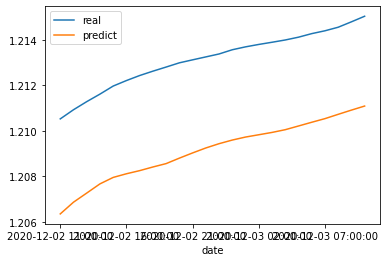

In [13]:
start = 120
end = start+24
SMA.iloc[start:end].plot()

In [14]:
pred = yhat.values.copy()
true = Y.values.copy()
pred_trend = []
true_trend = []
for i in range(len(pred)-24):
    if pred[i][1] >= pred[i+24][1]:
        pred_trend.append(0)
    else:
        pred_trend.append(1)

for i in range(len(true)-24):
    if true[i][1] >= true[i+24][1]:
        true_trend.append(0)
    else :
        true_trend.append(1)


In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_trend,true_trend)

0.49178403755868544

In [63]:
pred = yhat['close'].copy()
true = Y['close_24'].copy()

date
2020-11-25 13:00:00    1.18980
2020-11-25 14:00:00    1.18995
2020-11-25 15:00:00    1.19005
2020-11-25 16:00:00    1.19090
2020-11-25 17:00:00    1.19120
                        ...   
2021-01-14 17:00:00    1.20950
2021-01-14 18:00:00    1.20810
2021-01-14 19:00:00    1.20770
2021-01-14 20:00:00    1.20780
2021-01-14 21:00:00    1.20800
Name: close_24, Length: 876, dtype: float64

In [71]:
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope
pred_result = pred.rolling(24).apply(calc_slope,raw=False)
ture_result = true.rolling(24).apply(calc_slope,raw=False)
pred_trend = []
true_trend = []
pred_slope = pred_result.values
ture_slope = ture_result.values
for i in range(24,len(pred_slope)):
    if pred_slope[i] >= 0:
        pred_trend.append(1)
    else:
        pred_trend.append(0)

for i in range(24,len(ture_slope)):
    if ture_slope[i] >= 0:
        true_trend.append(1)
    else :
        true_trend.append(0)


In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_trend,true_trend)

0.5492957746478874

<AxesSubplot:xlabel='date'>

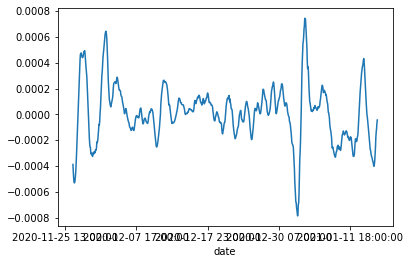

In [73]:
pred_result.plot()

<AxesSubplot:xlabel='date'>

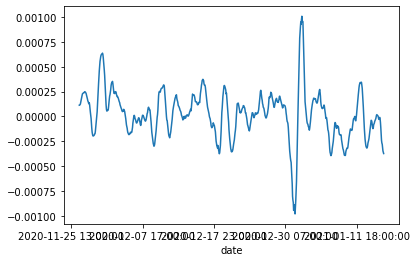

In [74]:
ture_result.plot()